In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSSB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 37.9983|-122.5372|       SNWD|USC00047880|     0|[00 00 00 00 00 0...|1904.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       SNWD|USC00047880|    10|[00 00 00 00 00 0...|1949.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       SNWD|USC00047880|     8|[00 00 00 00 00 0...|1950.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       SNWD|USC00047880|    10|[00 00 00 00 00 0...|1951.0|SSSBSSSB|
|     36.6| 37.9983|-122.5372|       SNWD|USC00047880|     6|[00 00 00 00 00 0...|1952.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

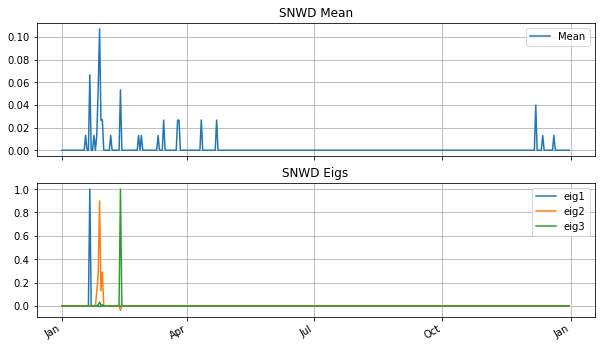

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

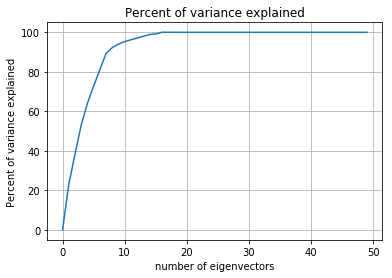

In [34]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:50]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [13]:
# count the rows which had zero snow in the entire year 
def count_zero_snow(row):
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    f = np.nan_to_num(Series)
    s = np.dot(f, f)
    if s != 0:
        return (1,1)
    else:
        return (0,1)
    
rdd10=df.rdd.map(count_zero_snow).reduceByKey(lambda x,y:x+y)
print rdd10.collect()
#df10=sqlContext.createDataFrame(rdd10)
#print df10.take(3)



[(0, 1912), (1, 18)]


In [14]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

#count the number of entries where the total_var is zero
print 'rows with zero snow', df2.filter(df2.total_var==0).count()  

before filter 1930
after filter 18
rows with zero snow 1912


In [15]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [46]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=3, row_n=2, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='r_m=%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [36]:
df4=df3.filter(df3.res_2<1).sort(df3.coeff_2)
print df4.count()
rows=df4.take(12)
df4.select('coeff_1','res_1','coeff_2','res_2').show(4)

18
+--------------------+------------------+--------------------+------------------+
|             coeff_1|             res_1|             coeff_2|             res_2|
+--------------------+------------------+--------------------+------------------+
|-0.18488886276654093|0.9999967109253806|  -3.978535022185049|0.9984737155135892|
|-0.12738197087048211| 0.999997918360835| -0.4432168637364077|0.9999727171112897|
|-0.10334342782501145| 0.999998165269076| -0.2662426147298843|0.9999859876665377|
|-0.10298635537770216|  0.99999816183102|-0.26416370995539445|0.9999860677641554|
+--------------------+------------------+--------------------+------------------+
only showing top 4 rows



In [37]:
df4=df3.filter(df3.res_2<.4).sort(df3.coeff_2)
print df4.count()
rows=df4.take(12)
df4.select('coeff_1','res_1','coeff_2','res_2').show()


6
+--------------------+-------------------+------------------+--------------------+
|             coeff_1|              res_1|           coeff_2|               res_2|
+--------------------+-------------------+------------------+--------------------+
|  126.93319024332813|7.23723859751337E-7|0.2381463947775876|8.414545845205739E-7|
|-0.12966502137576502| 0.9999728676930395|22.371769716134278| 0.19228840149493426|
|-0.12966502137576502| 0.9999728676930395|22.371769716134278| 0.19228840149493426|
|-0.21558742891222052| 0.9999878904278021| 52.08819494044406| 0.29308371014585577|
|-0.22142474683147007| 0.9999847377643872| 52.47089811168705| 0.14294129639215247|
|-0.23370912379102904|  0.999989472572698| 60.63852305285177| 0.29128014889078924|
+--------------------+-------------------+------------------+--------------------+



In [38]:
#df4.select('elevation','latitude','longitude', 'station','year','total_var','coeff_2','res_2').show()
df4.select('station','year','total_var','coeff_2','res_2').show()

+-----------+------+---------+------------------+--------------------+
|    station|  year|total_var|           coeff_2|               res_2|
+-----------+------+---------+------------------+--------------------+
|USC00046305|1962.0|  16129.0|0.2381463947775876|8.414545845205739E-7|
|USC00043652|1957.0|    625.0|22.371769716134278| 0.19228840149493426|
|USC00047661|1957.0|    625.0|22.371769716134278| 0.19228840149493426|
|USC00045915|1957.0|   3851.0| 52.08819494044406| 0.29308371014585577|
|USC00045915|1968.0|   3226.0| 52.47089811168705| 0.14294129639215247|
|USC00045915|1969.0|   5202.0| 60.63852305285177| 0.29128014889078924|
+-----------+------+---------+------------------+--------------------+



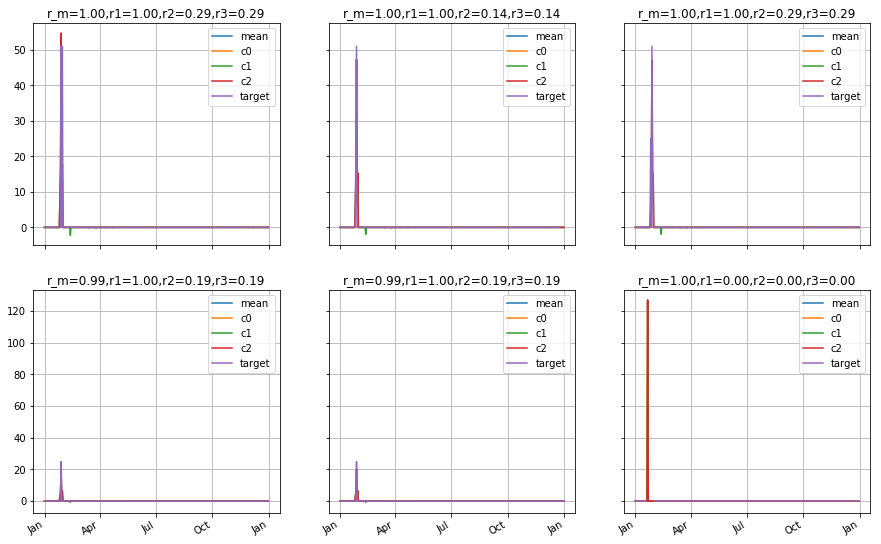

In [47]:
plot_recon_grid(rows)

In [40]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('coeff_2','res_2').show()

+------------------+--------------------+
|           coeff_2|               res_2|
+------------------+--------------------+
| 60.63852305285177| 0.29128014889078924|
| 52.47089811168705| 0.14294129639215247|
| 52.08819494044406| 0.29308371014585577|
|22.371769716134278| 0.19228840149493426|
|22.371769716134278| 0.19228840149493426|
|0.2381463947775876|8.414545845205739E-7|
+------------------+--------------------+



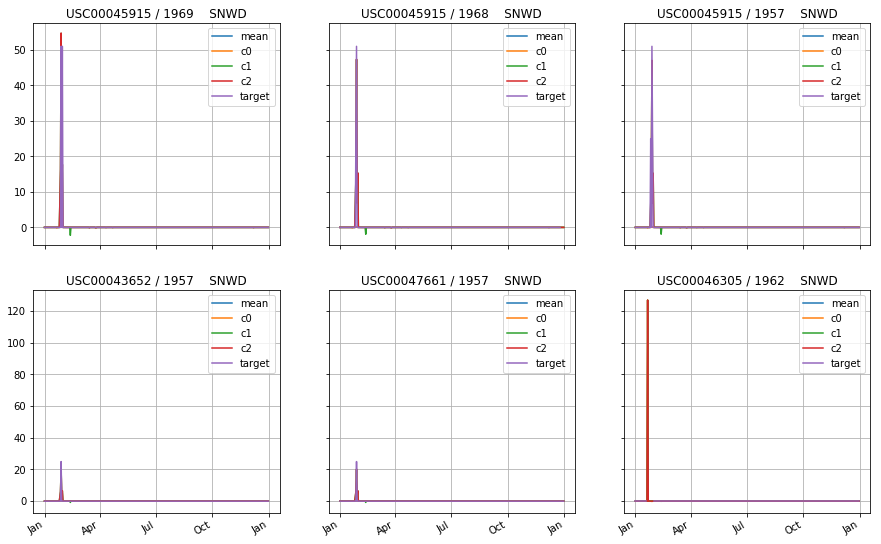

In [41]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

./lib/Eigen_decomp.py:66: RuntimeWarning: divide by zero encountered in divide
  _percent_explained=percent_explained[1:]/residual[0]


residual normalized norm  after mean: 0.997375591105
residual normalized norm  after mean + top eigs: [ 0.99998947  0.29128015  0.29030108]


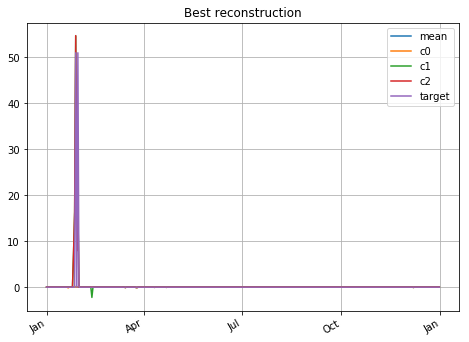

In [24]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [25]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    print 'val:', len(vals)
    P=np.arange(0,(1+1./(len(vals))),1./(len(vals)))
    #P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    print 'val:', len(vals)
    print P.shape
    print vals
    print P


    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

val: 18
val: 19
(19,)
[8.414545845205739e-07, 8.414545845205739e-07, 0.14294129639215247, 0.19228840149493426, 0.19228840149493426, 0.29128014889078924, 0.29308371014585577, 0.9287960647729302, 0.9842560954737082, 0.9984737155135892, 0.9999657464809151, 0.9999657569372083, 0.999965765259278, 0.9999657652592784, 0.9999657920455312, 0.9999727171112897, 0.9999807490934635, 0.9999859876665377, 0.9999860677641554]
[ 0.          0.05555556  0.11111111  0.16666667  0.22222222  0.27777778
  0.33333333  0.38888889  0.44444444  0.5         0.55555556  0.61111111
  0.66666667  0.72222222  0.77777778  0.83333333  0.88888889  0.94444444
  1.        ]


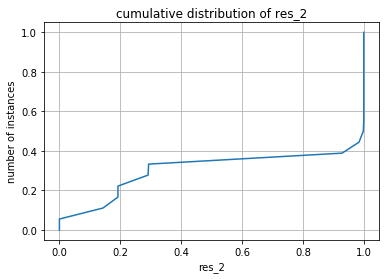

In [26]:
plot_CDF('res_2')

val: 18
val: 19
(19,)
[8.414545845205739e-07, 8.414545845205739e-07, 0.14294129639215247, 0.19228840149493426, 0.19228840149493426, 0.29128014889078924, 0.29308371014585577, 0.9287960647729302, 0.9842560954737082, 0.9984737155135892, 0.9999657464809151, 0.9999657569372083, 0.999965765259278, 0.9999657652592784, 0.9999657920455312, 0.9999727171112897, 0.9999807490934635, 0.9999859876665377, 0.9999860677641554]
[ 0.          0.05555556  0.11111111  0.16666667  0.22222222  0.27777778
  0.33333333  0.38888889  0.44444444  0.5         0.55555556  0.61111111
  0.66666667  0.72222222  0.77777778  0.83333333  0.88888889  0.94444444
  1.        ]


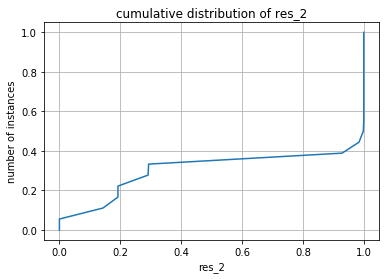

In [27]:
plot_CDF('res_2')

val: 18
val: 19
(19,)
[-3.978535022185049, -3.978535022185049, -0.4432168637364077, -0.2662426147298843, -0.26416370995539445, -0.13749142234344267, -0.12904624208337176, -0.1290250783615172, -0.1290082322524009, -0.12900823225239955, -0.1289539970573252, 0.2381463947775876, 3.1326717978718035, 20.26528111069606, 22.371769716134278, 22.371769716134278, 52.08819494044406, 52.47089811168705, 60.63852305285177]
[ 0.          0.05555556  0.11111111  0.16666667  0.22222222  0.27777778
  0.33333333  0.38888889  0.44444444  0.5         0.55555556  0.61111111
  0.66666667  0.72222222  0.77777778  0.83333333  0.88888889  0.94444444
  1.        ]


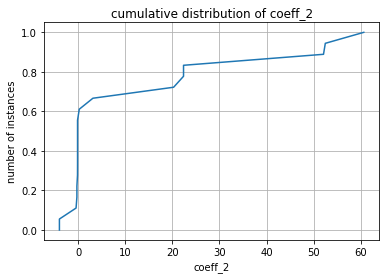

In [28]:
plot_CDF('coeff_2')

In [29]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [30]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.1M	../../Data/Weather/US_Weather_SSSBSSSB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SSSBSSSB_PRCP.parquet
216K	../../Data/Weather/decon_SSSBSSSB_SNWD.parquet
3.1M	../../Data/Weather/decon_SSSBSSSB_TOBS.parquet
